# PHYS20762 - Project 2 - Using numerical integration for an oscillator

Ramón Ciutad Pérez<br>
University of Manchester  
April 2022


# Abstract

The aim of this project is to experiment with and learn about numerical integration. To do this, we will apply four different methods to a system undergoing harmonic motion, i.e., an oscillator. The methods tested here are going to be Euler Method, Improved Euler Method, Verlet Method and, finally, Euler-Cromer Method. The objective behind this is being able to, in a  quantitative manner, determine which method is best and closest to the analytical solution.

Furthermore, throughout the report, we will experiment with different degrees of damping of the oscillator, as well as several types of forces acting upon the oscillator.

# Basic Theory

The equation of motion for the oscillator is:

$ m x''(t) + b x'(t) + kx(t) = F(t)  $ , 

where $x(t)$ is the time-dependent position of the oscillator, $m$ is the mass of the oscillator, $b$ is the damping term, $k$ is the spring's constant and $F(t)$ is the force that acts on the oscillator. Dividing through by the mass we obtain:

$ x''(t) + \gamma x'(t) + \omega_0^2x(t) = \frac{F(t)}{m}$ ,

where $\gamma = \frac{b}{m}$ and  $\omega_0 = \sqrt{\frac{k}{m}}$ is the natural frequency, i.e., frequency of the undamped oscillator.

Solving this differential equation alows us to find an equation for $x(t)$.

First, we will analyze the case where there is no external forces, i.e., $F(t) = 0$ . In this case it is vital to define $b_{cr}$, the critical damping term. It is the value of the damping term for which the oscillator comes back to the equilibrium position the fastest. It is relevant due to the fact that the analytic solution is different for whether the value of $b$ is smaller, greater or equal to that of $b_{cr}$. The critical damping term is calculated the following way: $b_{cr} = \sqrt{4km}$

Firstly, we consider the case where $ b < b_{cr}$, also known as underdamping or light damping. Here the time-dependent position is defined as:

$ x(t) = [A\cos(\omega t) + B\sin(\omega t)] \exp(-\frac{\gamma}{2}t)$ ,

where $A$ and $B$ are constants and $\omega = \sqrt{\omega_0^2 - \frac{\gamma^2}{4}}$  is the frequency of the damped oscillator.

Secondly, for the case of overdamping, i.e., when $ b > b_{cr}$, the position behaves as:

$ x(t) = \exp(-\frac{\gamma}{2}t) [A\exp(\alpha t) + B\exp(-\alpha t)]$ ,

where $\alpha$ is defined as: $ \alpha = \sqrt{\frac{\gamma^2}{4} - \omega_0^2}$

Finally, when there is critical damping ($ b = b_{cr}$), the position of the oscillator is defined as:

$ x(t) = \exp(-\frac{\gamma}{2}t) [A + Bt]$


# Part 1: Comparing four methods of numerical integration

We first start by initializing our Python interpreter

In [1]:
# Initialisation
import numpy as np
import matplotlib.pyplot as plt
import cmath

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

We also define some variables that will be useful later

In [22]:
TIME = 150 # (s)
INTERVAL_ARRAY = np.array([0.1, 0.05, 0.01]) # (s)
SPRING_CONSTANT = 1.79 # (kg/s**2)
MASS = 3.92 # (kg)
DAMPING_TERM = 0.1 # (kg/s)

critical_b = np.sqrt(4*SPRING_CONSTANT*MASS)
omega_0 = np.sqrt(SPRING_CONSTANT / MASS)

# Constants used in Section 3:
PUSH_TIME = 23 # (s) Time at which the push starts
PUSH_DURATION = 2 # (s) Duration of the push
FORCE_OMEGA = 1.5 # (rad/s) Angular frequency of the periodical force
FORCE_AMPLITUDE = 10 # (N)

Also, we define a function with the analytical solutions discussed above. Moreover, we define another function that will alow us later on to plot and compare both the analytic and numeric solutions for a given method

To express analytically the velocity as a function of time, we just have to differentiate with respect to time the expression we have for the position. 

In [12]:
def Analytic_Method(x_0, v_0, m, k, step, b=DAMPING_TERM):
    """
    Calculates an alayticial solution for a damped oscillator.
    Depending on the value of the damping term, it calculates a solution depending on
    whether the system is underdamped, overdamped or critically damped.

    Parameters
    ----------
    x_0 : Initial position
    v_0 : Initial velocity
    m : Mass of the oscillator
    k : Spring constant
    step : Step of integration
    b : Damping term. Quantifies how heavily damped the oscillator is

    Returns
    -------
    X : Numpy array of positions of the oscillator w.r.t. time
    V : Numpy array of velocities of the oscillator w.r.t. time
        
    """
    time = np.arange(0, TIME, step) # Create numpy array with values which range between 0 and the total time
    gamma = b / MASS
    
    if b < critical_b: # Underdamping
        # Constants
        A = (b/(2*1j*cmath.sqrt(4*k*m-b**2))+1/2)*x_0+v_0*m/(cmath.sqrt(4*k*m-b**2)*1j) 
        B = x_0-A
        # Formulae for X and V
        X = np.exp(-b*time/(2*m))*(A*np.exp(1j*cmath.sqrt(4*k*m-b**2)*time/(2*m))
                                  +B*np.exp(-1j*cmath.sqrt(4*k*m-b**2)*time/(2*m)))
        V = -b/(2*m)*X + np.exp(-b*time/(2*m))*(1j*cmath.sqrt(4*k*m-b**2)/(2*m))*(A*np.exp(1j*cmath.sqrt(4*k*m-b**2)*time/(2*m))
                                  -B*np.exp(-1j*cmath.sqrt(4*k*m-b**2)*time/(2*m)))
    
        return X.real, V.real # Return the real part of the result
    
    elif b == critical_b: # Critical damping
        # Constants
        A = x_0
        B = v_0 + A*gamma/2
        # Formulae for X and V
        X = (A + B*time) * np.exp(-gamma/2 * time)
        V = (B - gamma/2*(A + B*time)) * np.exp(-gamma/2 * time)
        
        return X, V
    
    else:
        # Constants
        omega_0 = np.sqrt(SPRING_CONSTANT/MASS)
        alpha = np.sqrt(gamma**2/4 - omega_0**2)
        B = (x_0 * (alpha - gamma/2) - v_0) / (2*alpha) 
        A = x_0 - B
        # Formulae for X and V
        X = (A*np.exp(alpha*time) + B*np.exp(-alpha*time)) * np.exp(-gamma/2 * time)
        V = (A*alpha*np.exp(alpha*time) - B*alpha*np.exp(-alpha*time)) * np.exp(-gamma/2 * time) - gamma/2*(A*np.exp(alpha*time) + B*np.exp(-alpha*time))*np.exp(-gamma/2 * time)
        
        return X, V

def plot_numeric_and_analytic(function, title, step_array, b=DAMPING_TERM):
    """
    Plots the position of the oscillator with respect to time for a certain
    numerical method along with the actual analytical solution
    
    """
    # Set up new plot and axes names
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Position (m)')
    
    for step in step_array: # For each step in the array, calculate numerically and plot the position w.r.t. time
        time = np.arange(0, TIME, step) # Create an array of the appropriate size for each step value
        ax.plot(time, function(0, -1, step, b)[0], label='step = {}'.format(step))

    x_analytic = Analytic_Method(0, -1, MASS, SPRING_CONSTANT, step, b)[0] # Calculate the analytical solution for the last step value
    ax.plot(time, x_analytic, '-.', label='Analytical solution', c='black') # Plot it
    ax.legend()
    plt.grid()
    plt.show()
    return None

# 1) Euler's Method

The Euler Method takes the first term in the Taylor expansion and results in:

$ a_i = -\frac{k}{m}x_i - \frac{b}{m}v_i  $ ,

$ v_{i+1} = v_i + ha_i $ ,

$ x_{i+1} = x_i + hv_i $ ,

where $x, v$ and $a$ are the position, velocity and acceleration, respectively. $h$ is the step size, i.e., the time difference between two consecutive points; and $i$ indicates the step number or index of a certain point.

Regarding the step size, it is clear that the smaller $h$ is, the more accurate the solution will be (up to a certain extent), but the longer it will take for the simulation to run (since there are more datapoints to compute). This is why, in the first part of the project, we will work with a range of values of h and compare the results they produce.

In [5]:
def Euler_Method(x_0, v_0, step, b=DAMPING_TERM):
    """
    Uses the Euler Method of integration to calculate the position and velocity of
    an oscillator w.r.t. time

    Parameters
    ----------
    x_0 : Initial position
    v_0 : Initial velocity
    step : Step of integration
    b : Damping term. Quantifies how heavily damped the oscillator is

    Returns
    -------
    x_array : Numpy array of positions of the oscillator w.r.t. time
    v_array : Numpy array of velocities of the oscillator w.r.t. time

    """
    nsteps = int(TIME/step) # Total number of steps
    x_array = np.zeros(nsteps) # Position array
    v_array = np.zeros(nsteps) # Speed array
    x_array[0] = x_0 # (m)
    v_array[0] = v_0 # (m/s)
    
    for i in range(nsteps - 1):
        a = -(SPRING_CONSTANT/MASS)*x_array[i] - (b/MASS)*v_array[i] # Acceleration as a function of position and velocity
        x_array[i+1] = x_array[i] + v_array[i]*step # Next position
        v_array[i+1] = v_array[i] + a*step # Next velocity
    
    return x_array, v_array

# 2) Improved Euler's Method

The Improved Euler Method is a better version of the previous one since it also takes the second term in the Taylor expansion of the position and results in:

$ a_i = -\frac{k}{m}x_i - \frac{b}{m}v_i  $ ,

$ v_{i+1} = v_i + ha_i $ ,

$ x_{i+1} = x_i + hv_i +  \frac{h^2}{2}a_i $ ,

In [6]:
def Improved_Euler_Method(x_0, v_0, step, b=DAMPING_TERM):
    """
    Uses the Improved Euler Method of integration to calculate the position and
    velocity of an oscillator w.r.t. time

    Parameters
    ----------
    x_0 : Initial position
    v_0 : Initial velocity
    step : Step of integration
    b : Damping term. Quantifies how heavily damped the oscillator is

    Returns
    -------
    x_array : Numpy array of positions of the oscillator w.r.t. time
    v_array : Numpy array of velocities of the oscillator w.r.t. time

    """
    nsteps = int(TIME/step) # Total number of steps
    x_array = np.zeros(nsteps) # Position array
    v_array = np.zeros(nsteps) # Speed array
    x_array[0] = x_0 # (m)
    v_array[0] = v_0 # (m/s)
    
    for i in range(nsteps-1):
        a = -(SPRING_CONSTANT/MASS)*x_array[i] - (b/MASS)*v_array[i] # Acceleration as a function of position and velocity
        x_array[i+1] = x_array[i] + v_array[i]*step + (step**2/2)*a # Next position
        v_array[i+1] = v_array[i] + a*step # Next velocity

    return x_array, v_array

# 3) Verlet's Method

Verlet Method comes from taking the centered derivative and after Taylor expanding the previous and next datapoints and doing some rearranging results in:

$ v_i = \frac{x_{i+1} - {x_{i-1}}}{2} $ ,

$ x_{i+1} = Ax_i + Bx_{i-1} $

where $ A = 2\frac{2m-kh^2}{D} $ , $ B = \frac{bh-2m}{D} $ , $ D = 2m + bh $

Note that the $i+1$th requires the $i$th and $i-1$th terms to be started. Therefore, another method must be used to find the first datapoint. In this case, the Euler-Cromer Method (discussed in the next section) was chosen for reason that will be talked about later.

In [7]:
def Verlet_Method(x_0, v_0, step, b=DAMPING_TERM):
    """
    Uses the Verlet Method of integration to calculate the position and
    velocity of an oscillator w.r.t. time

    Parameters
    ----------
    x_0 : Initial position
    v_0 : Initial velocity
    step : Step of integration
    b : Damping term. Quantifies how heavily damped the oscillator is

    Returns
    -------
    x_array : Numpy array of positions of the oscillator w.r.t. time
    v_array : Numpy array of velocities of the oscillator w.r.t. time

    """
    nsteps = int(TIME/step) # Total number of steps
    x_array, v_array = Euler_Cromer_Method(x_0, v_0, step) # Use another method for the first calculated value of x and v
    # Constants
    D = 2 * MASS + b * step
    A = 2 * (2*MASS - SPRING_CONSTANT*step**2) / D
    B = (b*step - 2*MASS) / D
    
    for i in range (2, nsteps):
        x_array[i] = A * x_array[i-1] + B * x_array[i-2] # Position
        v_array[i] = (x_array[i] - x_array[i-2]) / (2*step) # Velocity
        
    return x_array, v_array

# 4) Euler-Cromer Method

This method is consists in making a slight change in Euler's Method and calculating the $i+1$th datapoint of the position from the $i+1$th value of the velocity, instead of the $i$th. It leads to:

$ a_i = -\frac{k}{m}x_i - \frac{b}{m}v_i  $ ,

$ v_{i+1} = v_i + ha_i $ ,

$ x_{i+1} = x_i + hv_{i+1} $ ,

Also, note that in the code defining the function, we have included a line modifying the acceleration. This will be used later and corresponds to the applied force.

In [10]:
def Euler_Cromer_Method(x_0, v_0, step, b=DAMPING_TERM, force_0=0, time=TIME, omega=FORCE_OMEGA):
    """
    Uses the Euler-Cromer Method of integration to calculate the position and
    velocity of an oscillator w.r.t. time.
    This function will be used later on to compute an oscillator under a
    sinusoidal force.

    Parameters
    ----------
    x_0 : Initial position
    v_0 : Initial velocity
    step : Step of integration
    b : Damping term. Quantifies how heavily damped the oscillator is
    force_0 : Amplitude of the sinusoidal force
    time = time for which the simulation is run
    omega = angular frequency of the sinusoidal force

    Returns
    -------
    x_array : Numpy array of positions of the oscillator w.r.t. time
    v_array : Numpy array of velocities of the oscillator w.r.t. time

    """
    nsteps = int(time/step) # Total number of steps
    x_array = np.zeros(nsteps) # Position array
    v_array = np.zeros(nsteps) # Speed array
    x_array[0] = x_0 # (m)
    v_array[0] = v_0 # (m/s)

    for i in range(nsteps - 1):
        a = -(SPRING_CONSTANT/MASS)*x_array[i] - (b/MASS)*v_array[i] # Acceleration as a function of position and velocity
        a += force_0*np.sin(omega * step*i)/MASS # Include push due to periodic force (useful later)
        v_array[i+1] = v_array[i] + a*step # Next velocity
        x_array[i+1] = x_array[i] + v_array[i+1]*step # Next position
            
    return x_array, v_array

Now we run and plot these four methods to compare them. As initial conditions we have input 0 for the initial position and -1 m/s for the initial velocity.

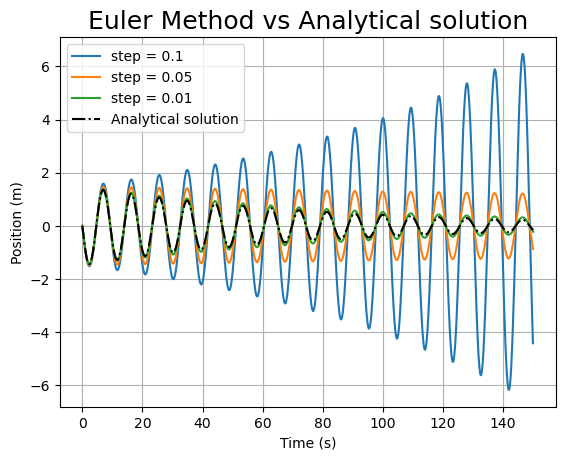

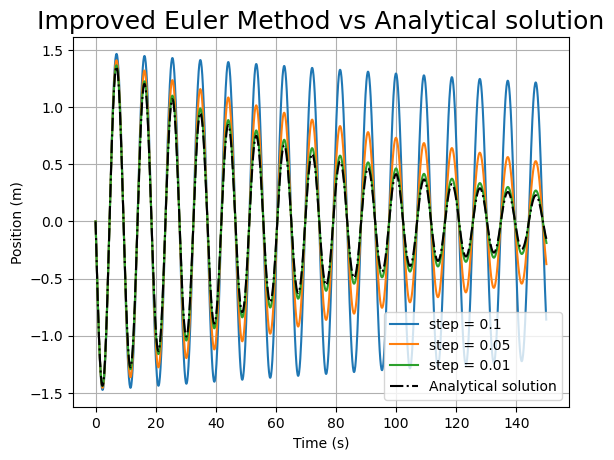

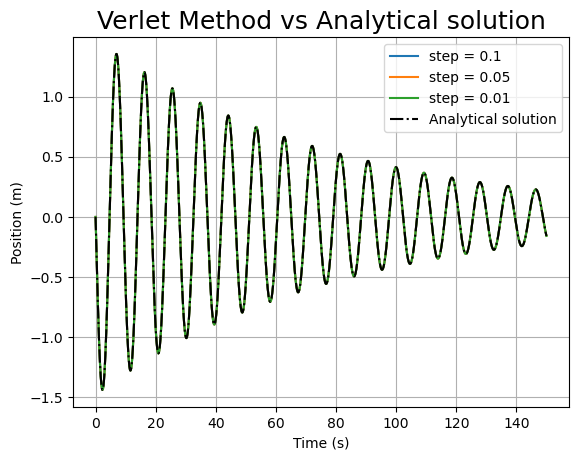

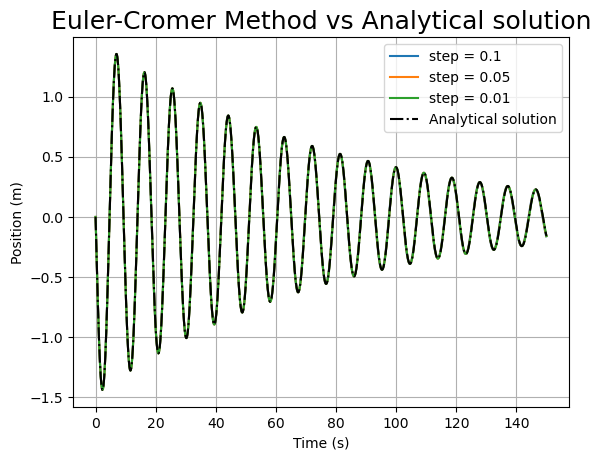

In [13]:
# Main code: call previously defined functions

plot_numeric_and_analytic(Euler_Method, 'Euler Method vs Analytical solution', INTERVAL_ARRAY)
plot_numeric_and_analytic(Improved_Euler_Method, 'Improved Euler Method vs Analytical solution', INTERVAL_ARRAY)
plot_numeric_and_analytic(Verlet_Method, 'Verlet Method vs Analytical solution', INTERVAL_ARRAY)
plot_numeric_and_analytic(Euler_Cromer_Method, 'Euler-Cromer Method vs Analytical solution', INTERVAL_ARRAY)

From what we observe we can say three main things:

1) As expected, as the stepsize decreases, the integration method becomes more accuarate, giving values closer to those provided by the analytical solution.

2) Both the Euler Method and the Improved Euler Method give solutions that are very dissimilar to the actual solution, especially in high stepsize values. Moreover, the Euler Method actually results in an increasing amplitude of oscillation for the largest step, which means that the energy is increasing as the oscillations occur. Considering we are working with light damping in this case, which impplies loss of energy when the oscillator is moving, the increasing energy predicted by the Euler Method is unphysical.

3) Both the Verlet's and Euler-Cromer methods are giving solutions very close to the analytical solution, even for large values of the step. This may be indicative that they are probably the best two methods.

To further analyze the energy for all four integration methods, we will proceed to compute and plot the energy for all of them (again, for several stepsizes) and compare it to the analytical solution.

To find the energy at any moment, we just have to add the kinetic energy and the potential energy of the oscillator:

$ E(t) = E_k(t) + E_p(t) = \frac{1}{2}mv^2(t) + \frac{1}{2}kx^2(t) $

We define two functions: one to calculate the energy at any time and another one to plot the numerical energy for several stepsizes along with the analytical one.

In [14]:
def calculate_energy(x_array, v_array):
    """
    Creates an array with energy values as time goes from the corresponding
    values of position and velocity, from which the potential and kinetic
    energies are computed
    
    """
    return 1/2*SPRING_CONSTANT*(x_array**2) + 1/2*MASS*(v_array**2)

def plot_energies(function, title, step_array):
    """
    Plots the energy as against time as calculated by a certain numerical
    integration method, as well as the actual energy computed analytically

    """
    # Set up new plot and axes names
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title, fontname='Times New Roman', fontsize=18)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Energy (J)')
    
    for step in step_array: # For each step in the array, calculate numerically and plot the energy w.r.t. time
        time = np.arange(0, TIME, step) # Create an array of the appropriate size for each step value
        numerical_energy = calculate_energy(function(0, -1, step)[0], function(0, -1, step)[1])
        ax.plot(time, numerical_energy, label='step = {}'.format(step))
    
    x_analytic, v_analytic = Analytic_Method(0, -1, MASS, SPRING_CONSTANT, step) # Calculate the position and velocity analytically for the last step value
    analytic_energy = calculate_energy(x_analytic, v_analytic) # Compute the energy analytically
    ax.plot(time, analytic_energy, '-.', label='Analytical solution', c='black') # Plot it
    ax.legend()
    plt.grid()
    plt.show()
    return None

And now call these functions

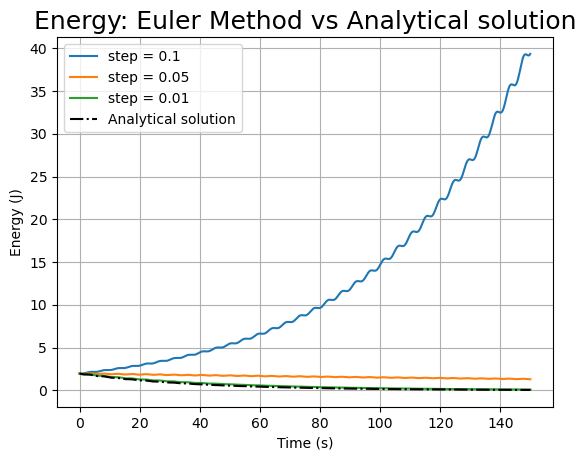

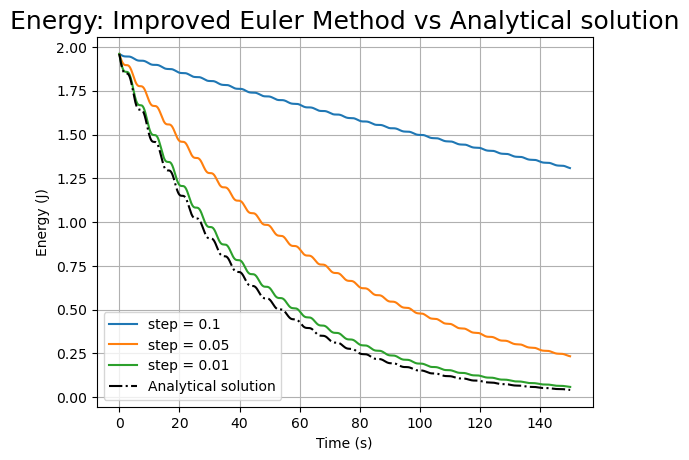

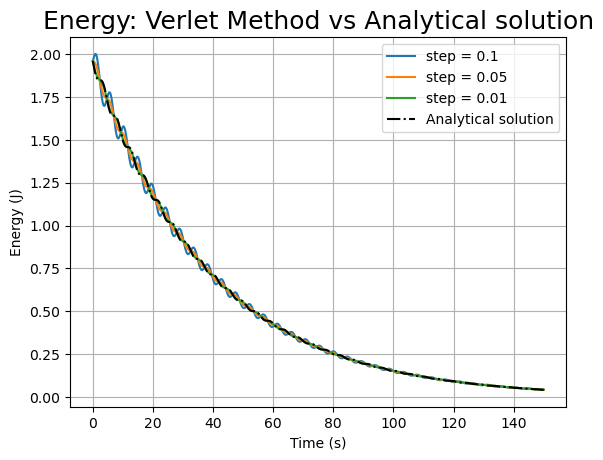

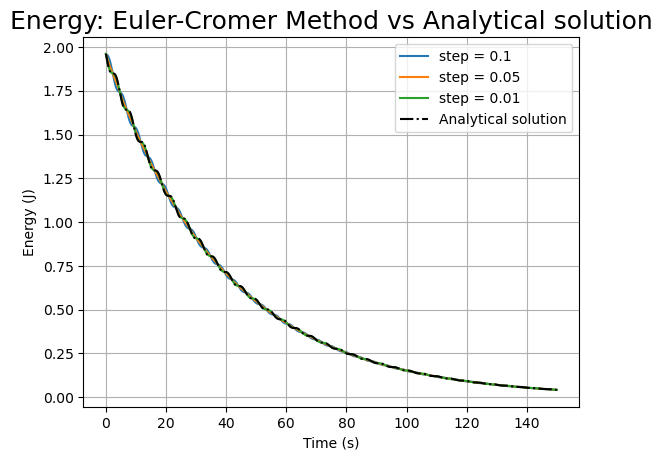

In [16]:
plot_energies(Euler_Method, 'Energy: Euler Method vs Analytical solution', INTERVAL_ARRAY)
plot_energies(Improved_Euler_Method, 'Energy: Improved Euler Method vs Analytical solution', INTERVAL_ARRAY)
plot_energies(Verlet_Method, 'Energy: Verlet Method vs Analytical solution', INTERVAL_ARRAY)
plot_energies(Euler_Cromer_Method, 'Energy: Euler-Cromer Method vs Analytical solution', INTERVAL_ARRAY)

As discussed previously, we can observe that when the step is 0.1 seconds for Euler's Method, the energy increases exponentially, which is indicative that it does not work very well with large stepsizes. Something similar can be said about the Improved Euler's method.

Additionally, note that for any method, even for the analytical solution, the energy graph is not a perfect decaying exponential. This is because energy losses take place when the oscillator is moving, and do so depending on its velocity. Therefore, we expect an oscillatory behavior along the exponential decay, which is exactly what we observe. 

It is clear by now that Verlet's and Euler-Cromer method outperform the other two, so the best method must be among these. For this reason, it is safe to discard Euler' and Improved Euler's methods. 

Now, to find the best method of the two remaining we are going to plot and compare the energy residuals, i.e., the energy difference between the numerical and anaylitcal solutions. However, we still need a quantitave measure of how good a method fits the analytic solution, and to get it, we will compute the standard deviation of the residuals for the lowest stepsize. This will essentially be a measure of the error of the method, and the best method should have the lowest error.

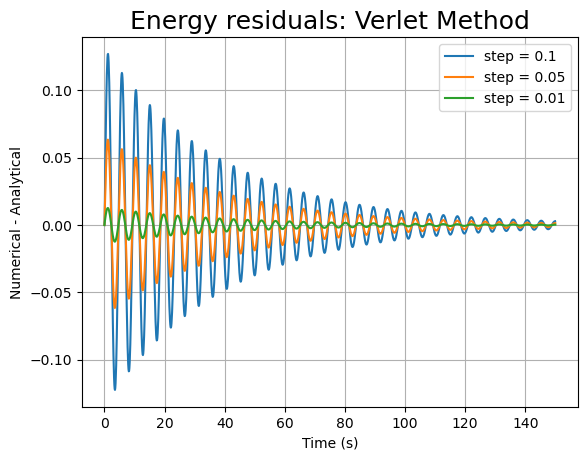

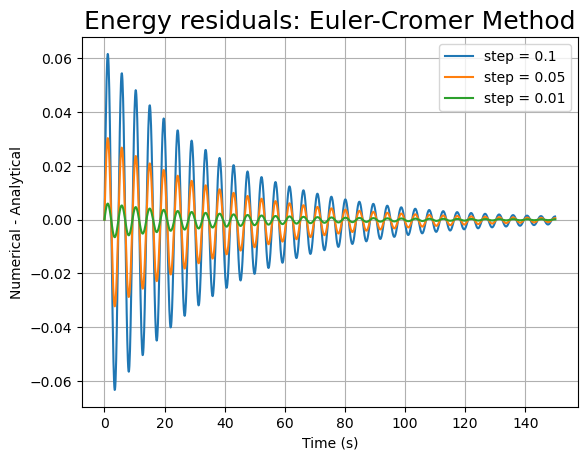

Expected uncertainty for Verlet Method: 3.387e-03
Expected uncertainty for Euler-Cromer Method: 1.704e-03


In [17]:
def plot_residuals(function, title, step_array):
    """
    Calculates and plots the residuals (difference between numerical and analytical
    solutions) for several step values

    """
    # Set up new plot and axes names
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title, fontname='Times New Roman', fontsize=18)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Numerical - Analytical')
    
    for step in step_array: # For each step in the array, calculate numerically and plot the energy residuals w.r.t. time
        time = np.arange(0, TIME, step) # Create an array of the appropriate size for each step value
        numerical_energy = calculate_energy(function(0, -1, step)[0], function(0, -1, step)[1])
        x_analytic, v_analytic = Analytic_Method(0, -1, MASS, SPRING_CONSTANT, step)
        analytic_energy = calculate_energy(x_analytic, v_analytic)
        residuals = numerical_energy - analytic_energy
        ax.plot(time, residuals, label='step = {}'.format(step))

    ax.legend()
    plt.grid()
    plt.show()
    return residuals

def calculate_sigma(residuals, step=INTERVAL_ARRAY[-1]):
    """
    Calculates the standard deviation of the energy residuals to quantify the
    'goodness' of each numerical integration method

    """
    nsteps = int(TIME/step) # Total number of steps
    return np.sqrt(1/nsteps * np.sum(residuals**2))

# Call functions to plot residuals and calculate sigma
verlet_residuals = plot_residuals(Verlet_Method, 'Energy residuals: Verlet Method', INTERVAL_ARRAY)
euler_cromer_residuals = plot_residuals(Euler_Cromer_Method, 'Energy residuals: Euler-Cromer Method', INTERVAL_ARRAY)

verlet_std = calculate_sigma(verlet_residuals)
euler_cromer_std = calculate_sigma(euler_cromer_residuals)

# Print sigma values
print('Expected uncertainty for Verlet Method: {0:4.3e}'.format(verlet_std))
print('Expected uncertainty for Euler-Cromer Method: {0:4.3e}'.format(euler_cromer_std))

From the graphs we can already tell that the Euler-Cromer oscillates between smaller values of the residuals. This is confirmed by the fact that the error on the Euler-Cromer Method is about half that of Verlet's Method. Consequently, we can state that the Euler-Cromer Method is the best one out of the four considered.

From now on, for the remaining parts of the project we will use said method to further study the behavior of the oscillator.

# Part 2: Studying different values of the damping term

Now that we have decided what the best integration method seems to be, we will consider more damped oscillations under different values of the damping term. In particular, we will study how it behaves when it is underdamped, overdamped and critically damped.

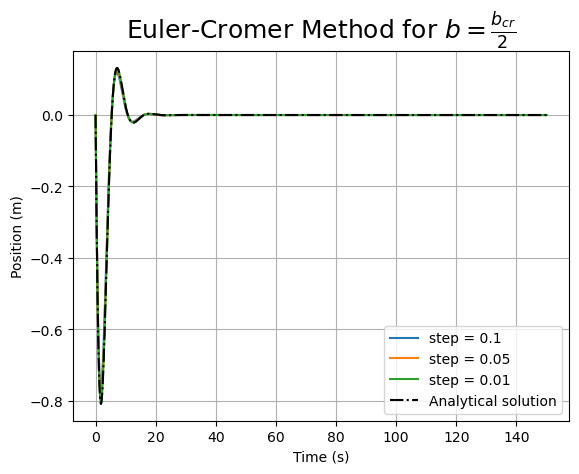

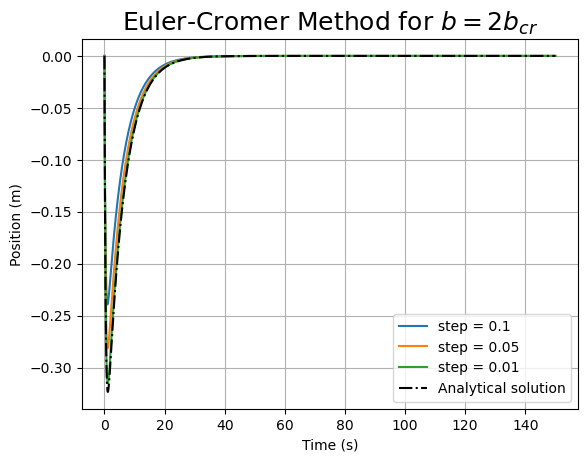

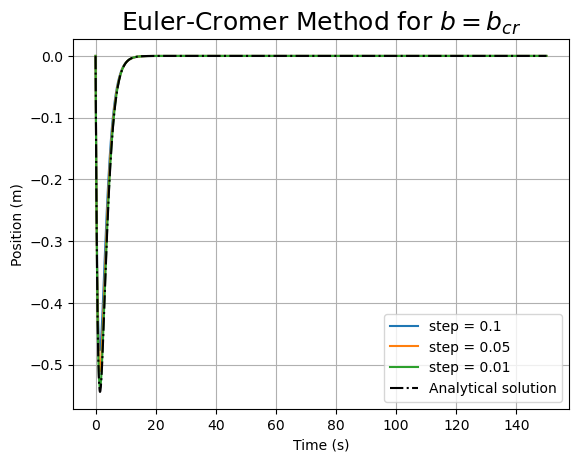

In [19]:
plot_numeric_and_analytic(Euler_Cromer_Method, r'Euler-Cromer Method for $b = \frac{b_{cr}}{2}$', INTERVAL_ARRAY, b=critical_b/2)
plot_numeric_and_analytic(Euler_Cromer_Method, r'Euler-Cromer Method for $b = 2b_{cr}$', INTERVAL_ARRAY, b=2*critical_b)
plot_numeric_and_analytic(Euler_Cromer_Method, r'Euler-Cromer Method for $b = b_{cr}$', INTERVAL_ARRAY, b=critical_b)

As we can notice, the Euler-Cromer method seems to break down slightly under overdamping and critical damping but still follows the analytical solution very well when the step is 0.01 seconds. 

Another important thing to comment is the fact that, as expected, when the system is critically damped, the oscillator goes to the equilibrium position more rapidly despite having a lower damping term. This is because under overdamping the system loses energy initally too fast, decreasing the velocity (on which the energy loss depends). In fact, this is why many human-made objects that are not meant to oscillate (such as bridges, car shock absorbers, etc.) are constructed in such a way that they undergo critical damping.

# Part 3: Studying the behavior under different forces

# 1) Sudden push

We begin this section by looking at a system to which we apply a sudden push after a few oscillations. This push can be in the same direction as the instantaneous velocity (positive psuh) or opposite to it (negative push).

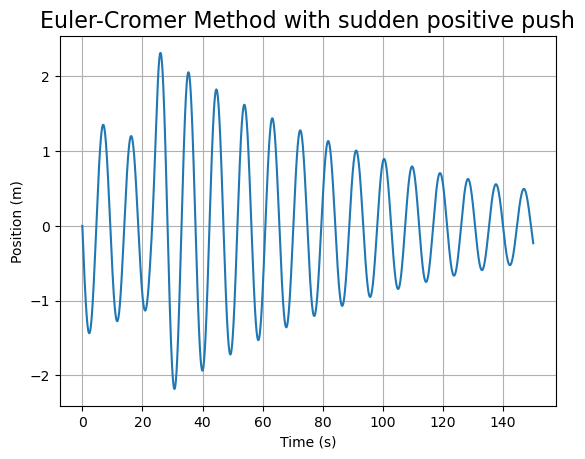

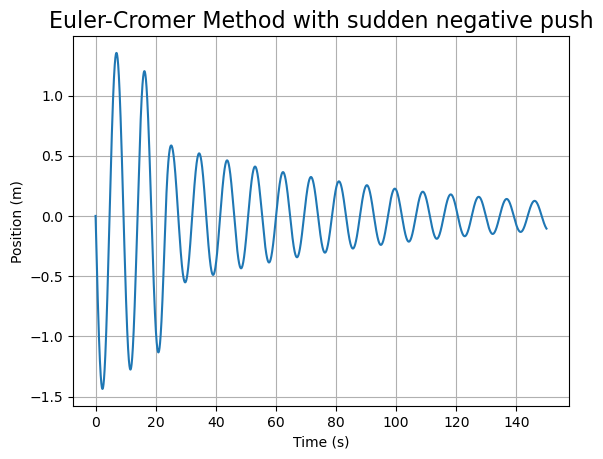

In [21]:
def Euler_Cromer_Method_with_push(x_0, v_0, step, push_coefficient, b=DAMPING_TERM, time=TIME):
    """
    Euler-Cromer Method but with a sudden push that can be in the same direction
    or opposite to the instantaneous velocity

    Parameters
    ----------
    x_0 : Initial position
    v_0 : Initial velocity
    step : Step of integration
    push_coefficient : quantifies how strong the push is, and whether it is in
                       the same direction as the velocity (positive) or opposite
                       (negative)
    b : Damping term
    time : Time for which the simulation is run

    Returns
    -------
    x_array : Numpy array of positions of the oscillator w.r.t. time
    v_array : Numpy array of velocities of the oscillator w.r.t. time

    """
    nsteps = int(time/step) # Total number of steps
    x_array = np.zeros(nsteps) # Position array
    v_array = np.zeros(nsteps) # Speed array
    x_array[0] = x_0 # (m)
    v_array[0] = v_0 # (m/s)
    push_steps = int(PUSH_DURATION/step)
    counter = 0

    for i in range(nsteps - 1):
        a = -(SPRING_CONSTANT/MASS)*x_array[i] - (b/MASS)*v_array[i]
        # Now we change the acceleration due to the push if the time is greater than the start time but lower than the start time + duration
        if step*i >= PUSH_TIME and counter <= push_steps:
            a += push_coefficient*v_array[i]*step
            counter += 1
        
        v_array[i+1] = v_array[i] + a*step
        x_array[i+1] = x_array[i] + v_array[i+1]*step
            
    return x_array, v_array

def plot_with_push(step):
    time = np.arange(0, TIME, step) # Create an array of the appropriate size for the step value
    # Set up new plot and axes names
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('Euler-Cromer Method with sudden positive push', fontsize=16)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Position (m)')
    ax.plot(time, Euler_Cromer_Method_with_push(0, -1, step, 50)[0], label='step = {}'.format(step)) # Plot position with positive push
    plt.grid()
    plt.show()
    # Set up new plot and axes names
    fig2 = plt.figure()
    ax = fig2.add_subplot(111)
    ax.set_title('Euler-Cromer Method with sudden negative push', fontname='Times New Roman', fontsize=16)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Position (m)')
    ax.plot(time, Euler_Cromer_Method_with_push(0, -1, step, -50)[0], label='step = {}'.format(step)) # Plot position with negative push
    plt.grid()
    plt.show()
    return None

# Call functions
plot_with_push(INTERVAL_ARRAY[-1])

The results are as expected: on the one hand, in the case of the positive push, because the applied force is in the same direction as the velocity, they add to a larger velocity. By the time the push ends, the amplitude of oscillation is larger that the initial amplitude (and therefore the energy is larger too). On the other hand, in the case of a negative push, the push acts in the same way as damping, and reduces the energy of the oscillator. In fact, if we let the push act for long enough, we should see how the amplitude of vibration essentally reduces to zero:

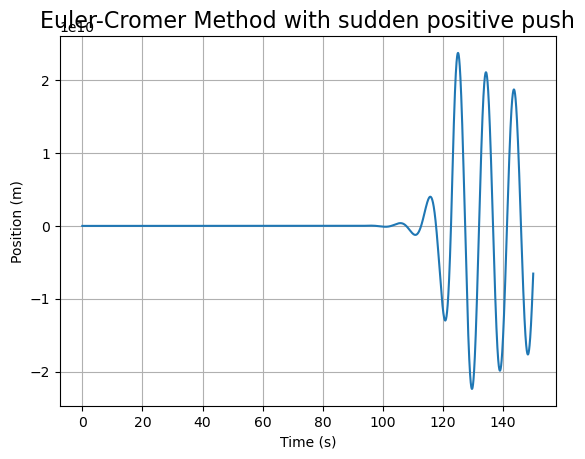

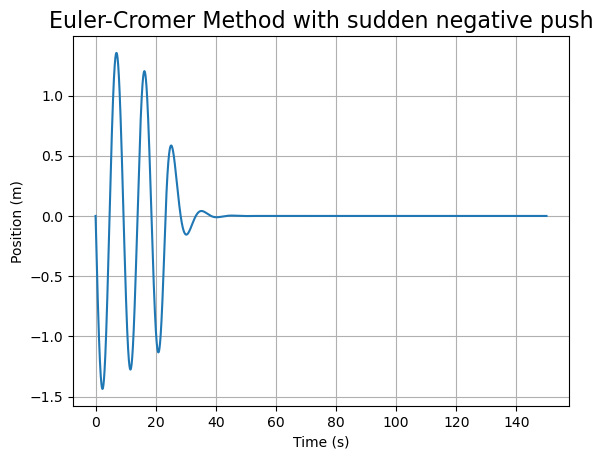

In [25]:
PUSH_DURATION = 100
plot_with_push(INTERVAL_ARRAY[-1])

# 2) Sinusoidal force

We now move on to a sinusoidal force on the oscillator. In this situation, the system undergoes an initial transient period where it 'adapts' itself to the external force, after which it oscillates with a relatively stable amplitude. We will focus on the behavior after the transient period.

For this case, we do have an analytic expression for the amplitude $A$ of the oscillator called "Amplitude Response Function":

$ A(\omega) = \frac{F_0}{m\sqrt{(\omega_0^2 - \omega)^2 + \omega^2\gamma^2}} $ ,

where $F_0$ is the magnitude of the applied force, and $\omega$ is the angular frequency of the applied force.

First, we start off by looking at the behavior of the system under a force with a trivial $\omega$

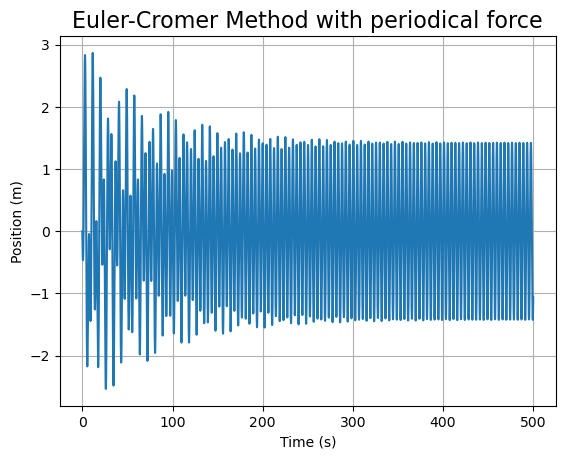

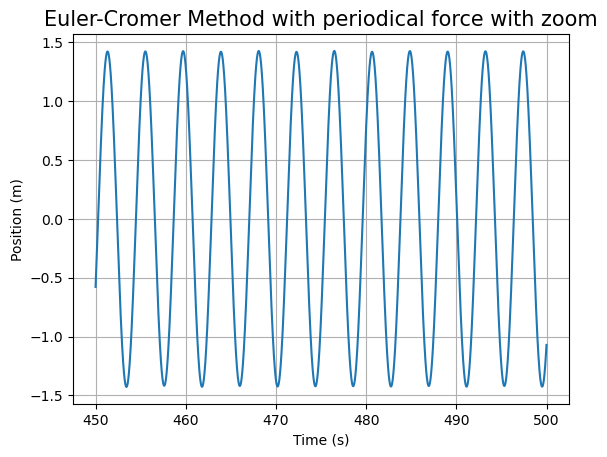

In [27]:
def plot_with_periodical_force(title, step):
    """
    Creates two plots for the Euler-Cromer Method with a sinusoidal force.
    The first one is the general plot, whereas the second one is zoomed into the
    last few oscillations

    """
    time_extended = 500 # Use an extended time because we want to focus on oscillations after the transient period
    # Set up new plot and axes names
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Position (m)')
    # Plot the total time and oscillations from 0 up to time_extended
    time = np.arange(0, time_extended, step)
    position = Euler_Cromer_Method(0, -1, step, force_0=FORCE_AMPLITUDE, time=time_extended)[0]
    ax.plot(time, position)
    plt.grid()
    plt.show()
    # Create a new plot now focusing on the last part of the simulation (after the transient period)
    fig2 = plt.figure()
    ax = fig2.add_subplot(111)
    ax.set_title(title + ' with zoom', fontsize=15)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Position (m)')
    ax.plot(time[-5000:-1], position[-5000:-1]) # Plot the last 5000 points of time and position
    plt.grid()
    plt.show()
    return None

plot_with_periodical_force('Euler-Cromer Method with periodical force', INTERVAL_ARRAY[-1])

In the first plot it can clearly be seen the transient behavior of the system until it settles down and oscillates more or less stably.

We now proceed to plot a number of amplitudes numerically against their corresponding angular frequencies. Additionally, we also plot on the same graph the analytic $A(\omega)$.

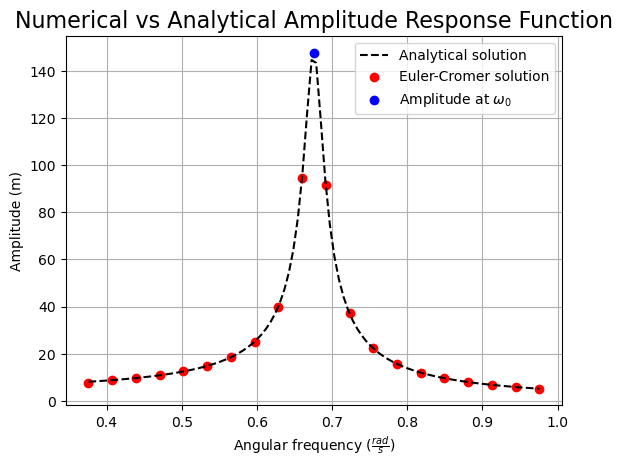

In [28]:
def numerical_forced_amplitude(step, omega):
    """
    Calculates the amplitude of the oscillator after the transient period for
    a given angular frequency

    """
    time_extended = 500
    position = Euler_Cromer_Method(0, -1, step, force_0=FORCE_AMPLITUDE, time=time_extended, omega=omega)[0]
    return max(position[-1000:-1]) #  Take the maximum value of the position during the last few oscillations as the amplitude

def analytical_forced_amplitude(omega, b=DAMPING_TERM):
    """
    Calculates analytically the amplitude of the oscillator as a function of
    the amplitude of the sinusoidal force as well as the angular frequency of
    the force (omega)

    """
    return FORCE_AMPLITUDE / np.sqrt(MASS**2 *(omega_0**2 - omega**2)**2 + omega**2 * b**2)

def plot_forced_amplitude(step):
    """
    Creates a plot of the resonance amplitude against a range oof values of the
    angular frequency os the applied sinusoidal force

    """
    omega_numerical_array = np.linspace(omega_0 - 0.3, omega_0 + 0.3, 20) # Create an array of a few values of the angular frequency for the numerical method
    numerical_amplitude = np.array([])
    omega_analytical_array = np.linspace(omega_0 - 0.3, omega_0 + 0.3, 100) # Create another array with more values since it takes less time analytically
    analytical_amplitude = np.array([])
    for omega in omega_numerical_array: # Calculate the corresponding numerical values of the amplitude
        numerical_amplitude = np.hstack((numerical_amplitude, numerical_forced_amplitude(step, omega)))
    for omega in omega_analytical_array: # Calculate the corresponding analytical values of the amplitude
        analytical_amplitude = np.hstack((analytical_amplitude, analytical_forced_amplitude(omega)))
    # Set up new plot and axes
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('Numerical vs Analytical Amplitude Response Function', fontsize=16)
    ax.set_xlabel(r'Angular frequency ($\frac{rad}{s}$)')
    ax.set_ylabel('Amplitude (m)')
    # Plot the numerical and analytical amplitudes against their corresponding arrays of omega
    ax.plot(omega_analytical_array, analytical_amplitude, '--', c='black', label='Analytical solution')
    ax.scatter(omega_numerical_array, numerical_amplitude, c='red', label='Euler-Cromer solution', zorder=2)
    # Create one extra data point for the natural frequency
    ax.scatter(omega_0, numerical_forced_amplitude(step, omega_0), c='blue', label=r'Amplitude at $\omega_{0}$') 
    ax.legend()
    plt.grid()
    plt.show()
    return None

plot_forced_amplitude(INTERVAL_ARRAY[-1])

As we can see, the analytic solution fits almost perfectly the numerically obtained values of the resonance amplitude. Note that the peak of the function corresponds to the natural frequency of the oscillator.

# 3) Step function

Finally, we are going to study how the system behaves under a force that goes as a step function.

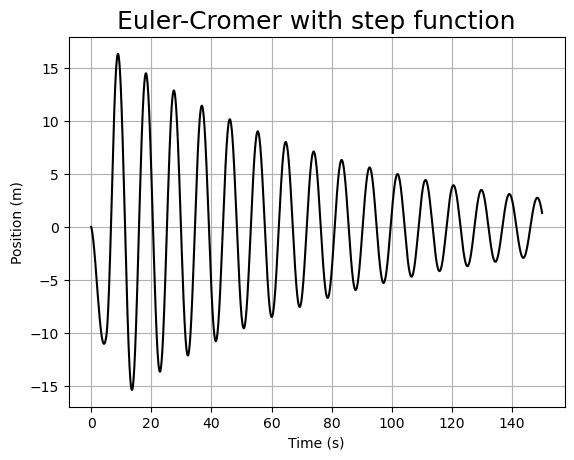

In [29]:
def Euler_Cromer_Method_with_step_function(x_0, v_0, force_0, omega, step=INTERVAL_ARRAY[-1], b=DAMPING_TERM, time=TIME):
    """
    Uses the Euler-Cromer Method of integration to calculate the position and
    velocity of an oscillator under a periodic step.function push w.r.t. time

    Parameters
    ----------
    x_0 : Initial position
    v_0 : Initial velocity
    force_0 : Amplitude of the sinusoidal force
    omega = angular frequency of the sinusoidal force
    step : Step of integration

    Returns
    -------
    x_array : Numpy array of positions of the oscillator w.r.t. time
    v_array : Numpy array of velocities of the oscillator w.r.t. time

    """
    nsteps = int(time/step)
    x_array = np.zeros(nsteps) # Position array
    v_array = np.zeros(nsteps) # Speed array
    x_array[0] = x_0 # (m)
    v_array[0] = v_0 # (m/s)
    period = 2*np.pi/omega
    counter = -500 # Counter used to apply the step function (we start with a negative push)

    for i in range(nsteps - 1):
        a = -(SPRING_CONSTANT/MASS)*x_array[i] - (b/MASS)*v_array[i]
        if counter >= 0 and counter < period/(2*step):
            a += force_0/MASS
        elif counter == period/(2*step):
            counter = -counter
        elif counter < 0:
            a += -force_0/MASS
        v_array[i+1] = v_array[i] + a*step
        x_array[i+1] = x_array[i] + v_array[i+1]*step
        counter += 1
            
    return x_array, v_array

def plot_extra_examples(function, title, omega, step=INTERVAL_ARRAY[-1]):
    """
    Plot position against time for a certain type of applied periodical force
    with a given angular frequency

    """
    # Set up new plot and axes
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title, fontname='Times New Roman', fontsize=18)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Position (m)')
    
    position = function(0, -1, FORCE_AMPLITUDE, omega)[0]
    time = np.arange(0, TIME, step)
    
    ax.plot(time, position, c='black') # Plot arrays of position and time
    plt.grid()
    plt.show()
    
plot_extra_examples(Euler_Cromer_Method_with_step_function, 'Euler-Cromer with step function', 1.5)

Here, I have chosen the counter in the code to start at -500 to better show how the system beahaves when the step function flips. As we can see, around 7 seconds, the force goes from negative to positive and is strong enough to actually invert the velocity. After this, we can see that the system adapts perfectly to the frequency of the step function and behaves as a nomrally damped oscillator.